<a href="https://colab.research.google.com/github/snehahampapura/Online-Retail-Customer-Segmentation/blob/main/Online_Retail_Customer_Segmentation_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Online Retail Customer Segmentation </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

#**Importing the necessary libraries and reading the file**

In [3]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
from numpy import math
import scipy.stats as stat
from datetime import datetime
import datetime as dt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import scipy.cluster.hierarchy as sch

from sklearn.cluster import AgglomerativeClustering

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
##Importing Dataset
dataset = pd.read_excel("/content/drive/MyDrive/Online Customer Segmentation/Online Retail.xlsx")
# dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/datasets/Online_Retail.xlsx - Online Retail.csv")

creating a copy of dataset

In [6]:
df = dataset.copy()

#**Defining necessary functions**

In [7]:
def check_duplicates(dataset):
  '''This function will print if there are duplicates in the dataset'''
  
  if(len(dataset[dataset.duplicated()])>0):
    print("There are duplicates in the data. The number of Duplicates are ",len(dataset[dataset.duplicated()]))
  else:
    print("There are no duplicates")

In [8]:
def visualize_missing_percent(dataset):
  '''This function takes the dataframe as input as the input and gives the count of missing values,
  missing values in percentage per column and plots the same in a bargraph'''
  
  #total percentage of missing data
  if dataset.isnull().sum().sum()>0:
    print("Missing values found..Calculating the total...")
    missing_data = dataset.isnull().sum()
    total_percentage = (missing_data.sum()/dataset.shape[0]) * 100
    print(f'The total number of missing entries found is {dataset.isnull().sum().sum()}, that is {round(total_percentage,2)}%')
    print('')

    # percentage of missing data per category
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent_total = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)*100
    missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
    missing_data = missing[missing['Total']>0]
    print(missing_data)
    print('')

    #Visualize the missing value percentage
    plt.figure(figsize=(9,6))
    sns.set(style="whitegrid")
    sns.barplot(x=missing_data.index, y=missing_data['Percentage'], data = missing_data)
    plt.title('Percentage of missing data by feature', fontsize=16)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.show()
  else:
    print('Hurray! There are no missing values in the data.')


In [9]:
def bargraph(df,X,Y,title):
  '''This function takes the columns of the dataframe as input 
  and gives barplot as output'''

  # Figure Size
  sns.set(rc={'figure.figsize':(19,7)})

  # creating the bar plot
  sns.barplot(x=X, y=Y, data=df,order=df[X],palette='flare_r')

  # set title
  plt.title(title, size=20)

  ## Showing the plot
  plt.show()


In [10]:
def time_type(time):
  '''This function takes the time as input and 
  gives time_type like morning,afternoon or evening has output'''
  if(time==6 or time==7 or time==8 or time==9 or time==10 or time==11):
    return 'Morning'
  elif(time==12 or time==13 or time==14 or time==15 or time==16):
    return 'Afternoon'
  else:
    return 'Evening'

In [11]:
def check_skew(df, column):
    '''This function is used to check and plot the skewness'''
    skew = stat.skew(df[column])
    skewtest = stat.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return 

In [12]:
def handle_neg_n_zero(num):
    '''This function is used to handle negative and zero values 
    so as to handle infinite numbers during log transformation'''
    if num <= 0:
        return 1
    else:
        return num

In [13]:
#Functions used in RFM model
def RScoring(x,p,d):
    '''Function to create Recency segment'''
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    '''Function to create Frequency and Monetary segment'''
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

#**Data Exploration**

In [14]:
print("The shape of the dataset is ",df.shape)

The shape of the dataset is  (541909, 8)


In [15]:
#Storing the rows of dataset
original_rows = df.shape[0]
original_rows

541909

In [16]:
#Familiarize with the dataset columns
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [18]:
#Checking the datatype of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [19]:
print("Lets take a look at the statistics of the columns")
df.describe(include='all')

Lets take a look at the statistics of the columns


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


**Potential data reversal.**

*  The max and min value of Quantity are both 80995; it could represent a 
reversal of data entry. However, the issue is that both the initial and reversal entry are retained in the dataset. Further investigation is needed to understand the nature and determine the best way to manage such data reversal.

**Potential indication of cancellation orders from negative UnitPrice.**

*  It is uncommon to have negative UnitPrice, as this would mean a cash outflow to a company. These transactions could represent cancelled orders by customers or bad-debt incurred by the business.

###**Checking for Duplicate**

In [20]:
#Checking for duplicates
check_duplicates(df)

There are duplicates in the data. The number of Duplicates are  5268


Lets drop duplicates in the data.

In [21]:
df.drop_duplicates(keep = False, inplace = True)

In [22]:
df.shape

(531762, 8)

In [23]:
#Checking for duplicates
check_duplicates(df)

There are no duplicates


###**Checking for Null/Missing Values**

In [24]:
#Familiarise with the columns in the dataset and their data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531762 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531762 non-null  object        
 1   StockCode    531762 non-null  object        
 2   Description  530308 non-null  object        
 3   Quantity     531762 non-null  int64         
 4   InvoiceDate  531762 non-null  datetime64[ns]
 5   UnitPrice    531762 non-null  float64       
 6   CustomerID   396767 non-null  float64       
 7   Country      531762 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.5+ MB


Missing values found..Calculating the total...
The total number of missing entries found is 136449, that is 25.66%

              Total  Percentage
CustomerID   134995   25.386357
Description    1454    0.273431



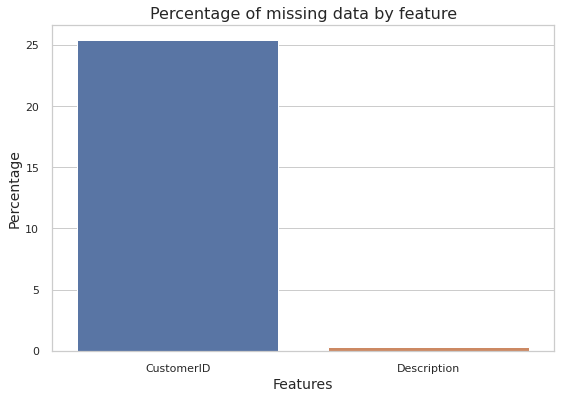

In [25]:
visualize_missing_percent(df)


We can observe that 25% of CustomerID values are missing.
<br>

CustomerID is an unique identifier for each customer.And the missing unique identifier of customers could post a problem as market/customer segmentation requires grouping each unique customer into a group.
<br>

So, we have to deal with this missing values.

This can be handled in multiple ways. One such way is by imputing it with a random number.
<br>

Missing CustomerID can be imputed with a random number that is not existed in the dataset. Since this is an online purchase, these transactions could be made under 'Guest Checkout' which doesn't require the customer to create account.
<br>

Though it is possible to impute customerID based on unique value of InvoiceNo, but there will be a big inaccuracy in matching cancelled transactions. Because, we have observed that the corresponding purchase and cancelled transaction do not have same InvoiceNo.
<br> 

And this kindof purchase will be likely to be a one-time purchase as customers who shop frequently would probably create an account for ease of purchasing.
<br>

So, its better to drop the missing values.

In [26]:
df.dropna(inplace=True)

In [27]:
visualize_missing_percent(df)

Hurray! There are no missing values in the data.


In [28]:
#Storing number of rows
new_rows = df.shape[0]

In [29]:
print(round((new_rows/original_rows)*100,2),"% of data is retained after cleaning and analysis")

73.22 % of data is retained after cleaning and analysis


#**Exploratory Data Analysis**

##**Data Preprocessing**

Create a new column **TotalAmount** by combining UnitPrice and Quantity.

In [30]:
df['TotalAmount'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Convert **InvoiceDate** to datatime format. And split them into hour, min, day, month, year columns

In [31]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396767 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    396767 non-null  object        
 1   StockCode    396767 non-null  object        
 2   Description  396767 non-null  object        
 3   Quantity     396767 non-null  int64         
 4   InvoiceDate  396767 non-null  datetime64[ns]
 5   UnitPrice    396767 non-null  float64       
 6   CustomerID   396767 non-null  float64       
 7   Country      396767 non-null  object        
 8   TotalAmount  396767 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.3+ MB


In [33]:
df['month']=df['InvoiceDate'].dt.month_name()
df['day'] = df['InvoiceDate'].dt.day_name()
df['year'] = df['InvoiceDate'].dt.year
df["hour"] = df["InvoiceDate"].apply(lambda x: x.hour)
df["minute"] = df["InvoiceDate"].apply(lambda x: x.minute)

Since we are having 1 year of data. Let's drop year column.
<br>
And 'hour' column will be sufficient for our analysis so, we will be utilizing hour column and dropping of minute column.

In [34]:
df.drop(columns=['year','minute'],axis=1,inplace=True)

In [35]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,month,day,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,December,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,December,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December,Wednesday,8


##**Analysis of Columns**

In [36]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalAmount', 'month', 'day',
       'hour'],
      dtype='object')

###**Invoice Number**

Invoice number is a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

Now let us now look at the number of canceled orders in the data.

In [37]:
# String to be searched in start of string 
search ="C"
  
# boolean series returned with False at place of NaN
bool_series = df["InvoiceNo"].str.startswith(search, na=False)
  
# displaying filtered dataframe
cancel_order = df[bool_series]

cancel_order.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,month,day,hour
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,December,Wednesday,9
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,December,Wednesday,9
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,December,Wednesday,10
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,December,Wednesday,10
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,December,Wednesday,10


In [38]:
print("Shape of cancelled order", cancel_order.shape)

Shape of cancelled order (8844, 12)


In [39]:
cancel_order_percentage = cancel_order['InvoiceNo'].count()*100/df['InvoiceNo'].count()
print("We have about ",round(cancel_order_percentage,2),"% of cancelled orders.")

We have about  2.23 % of cancelled orders.


###**Country**

**Top 10 countries with most cancelled Orders**

In [40]:
## Apply groupby function on country and Invoice No.
cancel_order_country = cancel_order.groupby('Country')['InvoiceNo'].count().reset_index()

In [41]:
## From cancel_order_country variable finding top 10 countries with cancelled order
cancel_order_country_top10 = cancel_order_country.sort_values('InvoiceNo',ascending=False, ignore_index=True).head(10)
cancel_order_country_top10 = cancel_order_country_top10.rename({'InvoiceNo':'Num of order cancelled'},axis=1)
cancel_order_country_top10

,Country,Num of order cancelled
0,United Kingdom,7474
1,Germany,453
2,EIRE,247
3,France,147
4,USA,112
5,Australia,74
6,Spain,48
7,Italy,45
8,Belgium,38
9,Japan,37


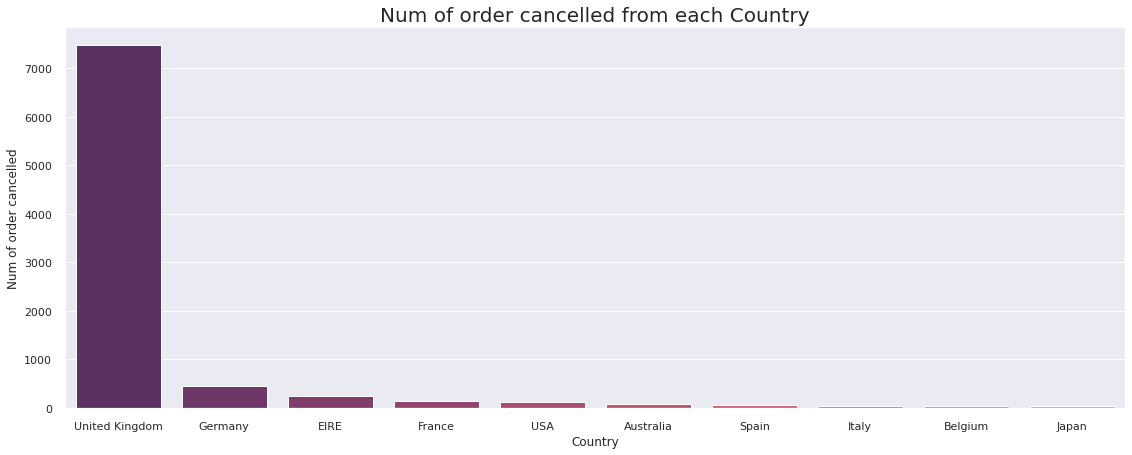

In [42]:
bargraph(cancel_order_country_top10,'Country','Num of order cancelled','Num of order cancelled from each Country')

From the above graph we can observe that cancelled orders will be more in UK.

Let's remove the cancelled order data from the dataset.

In [43]:
df = df[~df.InvoiceNo.str.contains("C", na=False)]

**Top 10 countries with most orders**

In [44]:
## Apply groupby function on country and Invoice No.
country_count = df.groupby('Country')['InvoiceNo'].count().reset_index()

In [45]:
country_count.head()

,Country,InvoiceNo
0,Australia,1183
1,Austria,398
2,Bahrain,17
3,Belgium,2031
4,Brazil,32


In [46]:
## From country_count variable finding top 10 countries
Top_ten_country = country_count.sort_values('InvoiceNo', ascending=False, ignore_index=True).head(10)

In [47]:
## Adding country percentage column to top 10 countries data frame
Top_ten_country['Country_percent']= round(Top_ten_country['InvoiceNo']*100/df['InvoiceNo'].count(),2)
Top_ten_country = Top_ten_country.rename({'Country_percent':'Percentage of Order'},axis=1)
Top_ten_country

,Country,InvoiceNo,Percentage of Order
0,United Kingdom,344490,88.80
1,Germany,9012,2.32
2,France,8312,2.14
3,EIRE,7218,1.86
4,Spain,2475,0.64
5,Netherlands,2363,0.61
6,Belgium,2031,0.52
7,Switzerland,1842,0.47
8,Portugal,1445,0.37
9,Australia,1183,0.30


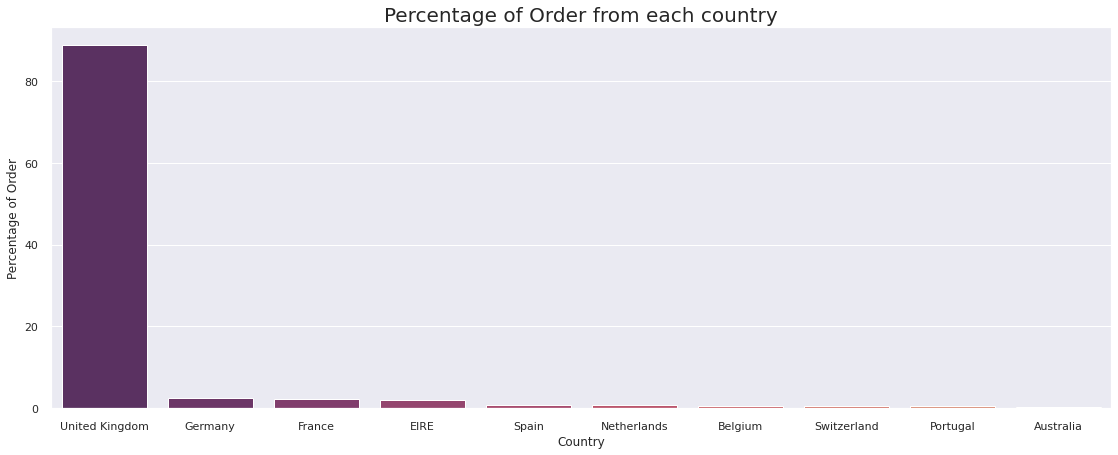

In [48]:
#Plotting barplot
bargraph(Top_ten_country,'Country','Percentage of Order','Percentage of Order from each country')

About 88.8% of orders are coming from UK, so we can say that most customers and most orders will be from United Kingdom.

**Bottom 10 countries with orders**

In [49]:
## Apply groupby function on country and Invoice No.
country_count = df.groupby('Country')['InvoiceNo'].count().reset_index()

In [50]:
## From country_count variable finding bottom 10 countries
Bottom_ten_country = country_count.sort_values('InvoiceNo', ascending=True, ignore_index=True).head(10)
Bottom_ten_country = Bottom_ten_country.rename({'InvoiceNo':'Num of orders'},axis=1)
Bottom_ten_country

,Country,Num of orders
0,Saudi Arabia,9
1,Bahrain,17
2,Czech Republic,25
3,Brazil,32
4,Lithuania,35
5,Lebanon,45
6,RSA,58
7,European Community,60
8,United Arab Emirates,68
9,Malta,112


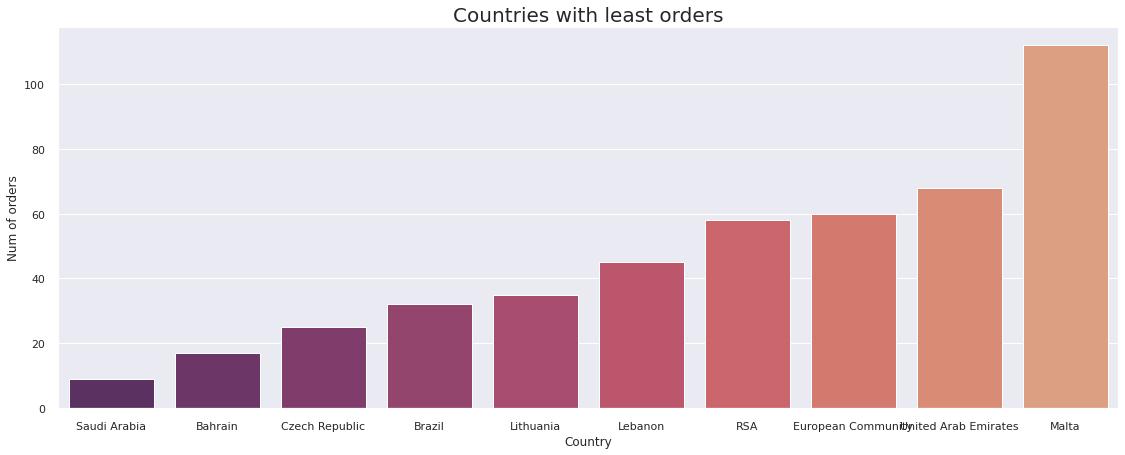

In [51]:
bargraph(Bottom_ten_country,'Country','Num of orders','Countries with least orders')

We have least number of orders and customers from Saudi Arabia.

###**CustomerID and TotalAmount**

CustomerId is a unique ID which is used to represent Customer.
<br>
Now, lets analyse which customer spends most amount on shopping.

In [52]:
#grouo custID based on the totalamount they spent
CustAmount = df.groupby(["CustomerID"]).TotalAmount.sum().sort_values(ascending = False).iloc[:20].reset_index()
CustAmount.head(10)

,CustomerID,TotalAmount
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194230.79
3,16446.0,168472.50
4,14911.0,143597.28
5,12415.0,124914.53
6,14156.0,117040.53
7,17511.0,91062.38
8,16029.0,80676.84
9,12346.0,77183.60


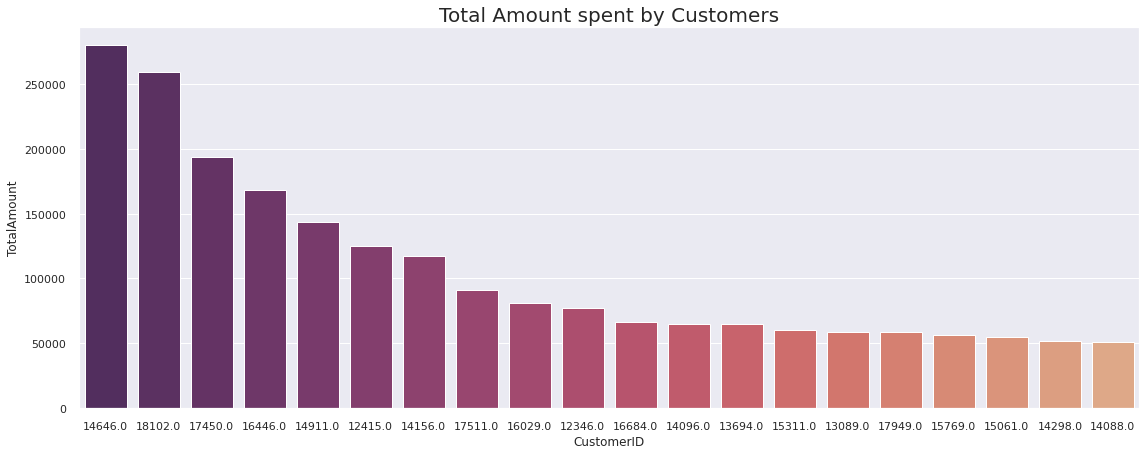

In [53]:
bargraph(CustAmount,'CustomerID','TotalAmount','Total Amount spent by Customers')

We can say that the customer with customerID - 14646, spends more money on shopping.

###**CustomerID and InvoiceNumber**

In [54]:
#group custID with number of invoice generated for them . This gives us the total number of order they made
Most_shopped = df.groupby(["CustomerID"]).InvoiceNo.count().sort_values(ascending = False).iloc[:20].reset_index()
Most_shopped.head(10)

,CustomerID,InvoiceNo
0,17841.0,7523
1,14911.0,5667
2,14096.0,5111
3,12748.0,4243
4,14606.0,2654
5,15311.0,2353
6,14646.0,2080
7,13089.0,1810
8,13263.0,1657
9,14298.0,1637


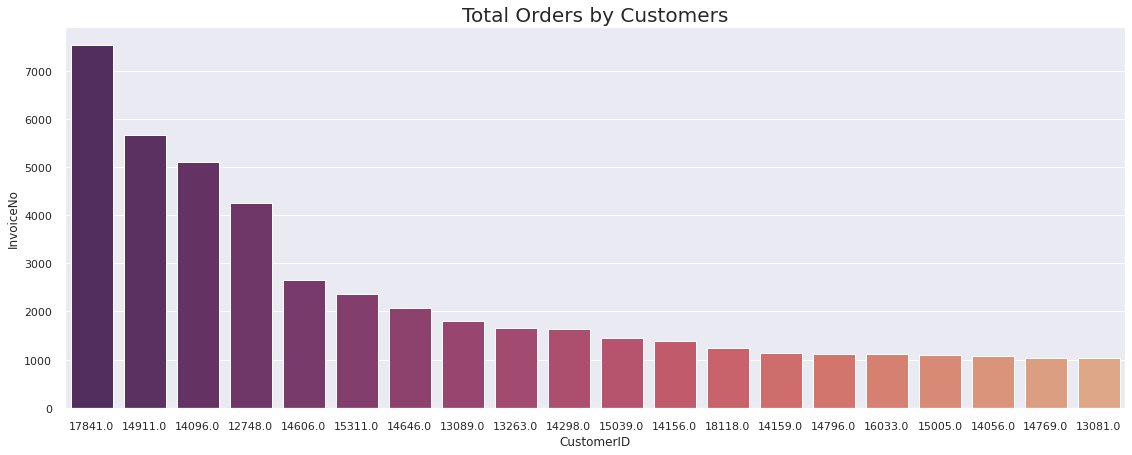

In [55]:
bargraph(Most_shopped,'CustomerID','InvoiceNo','Total Orders by Customers')

We can say that the customer with customerID - 17841 is a shopaholic, who shops/orders more.

###**Day**

In [56]:
#Creating day_df to store number of order on each day_name
day_df=df['day'].value_counts().reset_index()
day_df.rename(columns={'index': 'Day_Name'}, inplace=True)
day_df.rename(columns={'day': 'Count'}, inplace=True)
day_df

,Day_Name,Count
0,Thursday,78514
1,Wednesday,67258
2,Tuesday,65072
3,Monday,63608
4,Sunday,59800
5,Friday,53671


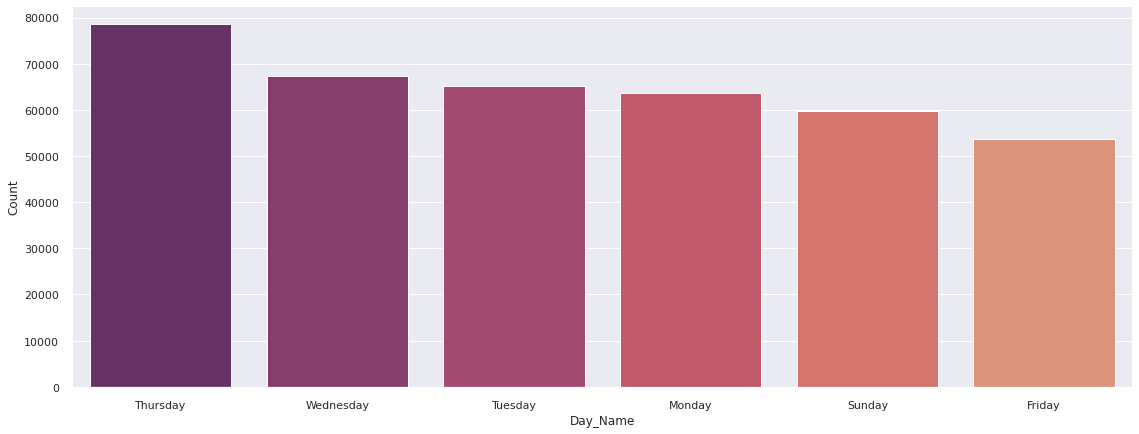

In [57]:
#plot bar plot
bargraph(day_df,'Day_Name','Count','')

We can observe that shopping is more on weekdays compared to weekend.

###**Month**

In [58]:
#creating month_df to store number of orders in each month
month_df=df['month'].value_counts().reset_index()
month_df.rename(columns={'index': 'Month_Name'}, inplace=True)
month_df.rename(columns={'month': 'Count'}, inplace=True)
month_df

,Month_Name,Count
0,November,61914
1,October,48099
2,December,41999
3,September,39335
4,May,27840
5,June,26710
6,March,26592
7,August,26586
8,July,26344
9,April,22240


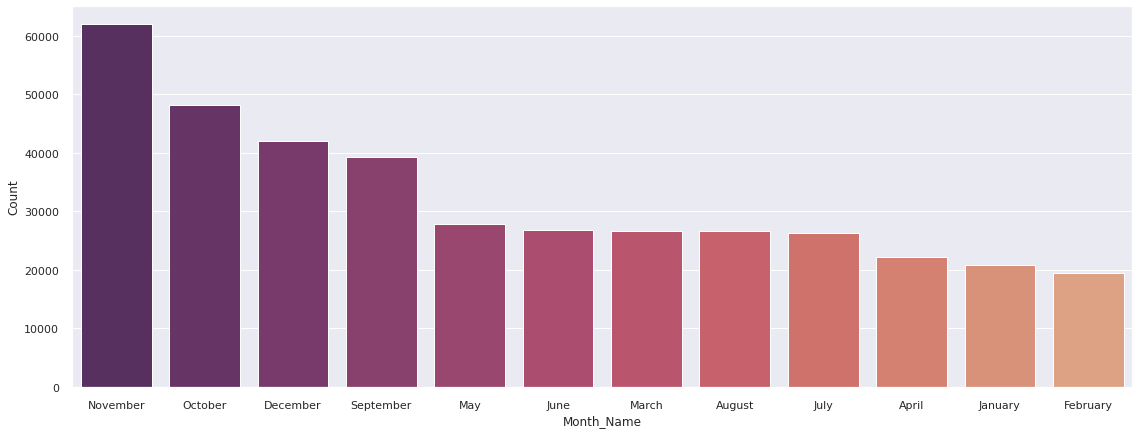

In [59]:
#plotting bar plot
bargraph(month_df,'Month_Name','Count','')

Shoppings will be more on year ends i.e, Sep, Oct, Nov and Dec.
<br>
We can even say that since festivals will be more during this period shopping will be more.

###**Hour**

In [60]:
#creating hour_df to store number of orders every hour
hour_df=df['hour'].value_counts().reset_index()
hour_df.rename(columns={'index': 'Hour_Name'}, inplace=True)
hour_df.rename(columns={'hour': 'Count'}, inplace=True)
hour_df

,Hour_Name,Count
0,12,69889
1,13,62081
2,14,52465
3,11,47718
4,15,44253
5,10,37569
6,16,23381
7,9,21912
8,17,12814
9,8,8685


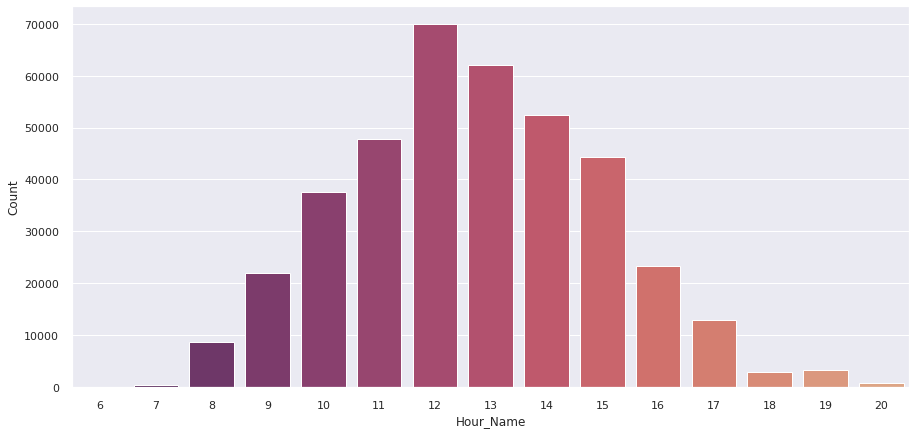

In [61]:
plt.figure(figsize=(15,7))
sns.barplot(x='Hour_Name',y='Count',data=hour_df,palette='flare_r')
plt.show()

In [62]:
##Splitting into 3 groups such as morning, afternoon and evening based on timings.
df['Time_type']=df['hour'].apply(time_type)

<function matplotlib.pyplot.show(*args, **kw)>

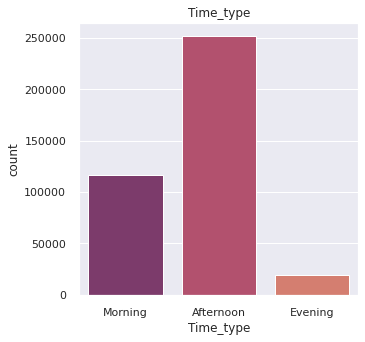

In [63]:
plt.figure(figsize=(5,5))
plt.title('Time_type')
sns.countplot(x='Time_type',data=df,palette='flare_r')
plt.show

We can observe that most of the purchase happens during afternoon.

###**Description**

In [64]:
#Creating Description_df to store number of orders for every product
Description_df=df['Description'].value_counts().reset_index()
Description_df.rename(columns={'index': 'Description_Name'}, inplace=True)
Description_df.rename(columns={'Description': 'Count'}, inplace=True)
Description_df.head()

,Description_Name,Count
0,WHITE HANGING HEART T-LIGHT HOLDER,2005
1,REGENCY CAKESTAND 3 TIER,1704
2,JUMBO BAG RED RETROSPOT,1612
3,PARTY BUNTING,1383
4,ASSORTED COLOUR BIRD ORNAMENT,1382


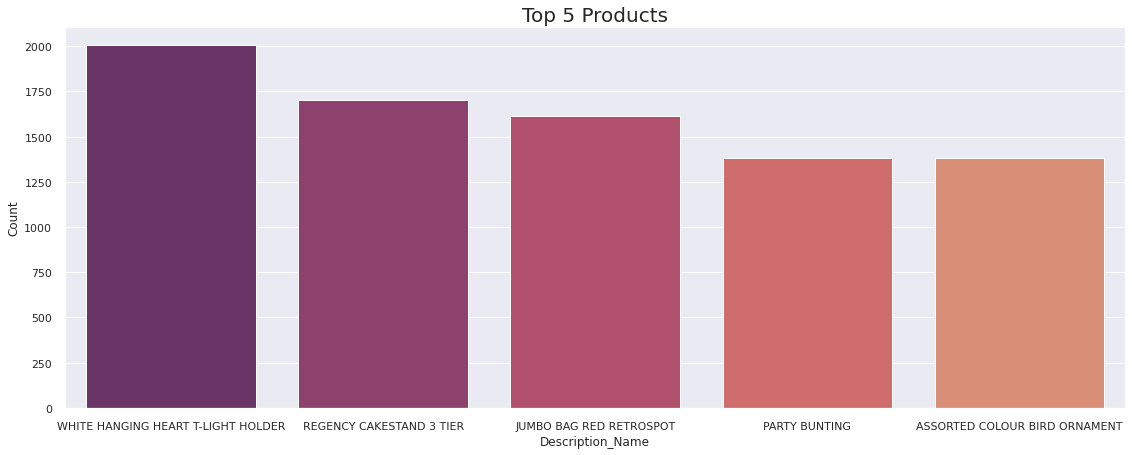

In [65]:
#plotting bar plot
bargraph(Description_df[:5],"Description_Name","Count","Top 5 Products")

The top 5 selling products are as follows -

1.   White Hanging Heart T-Light Holder
2.   Regency Cakestand 3 tier 

1.   Jumbo Bag Red Retrospot
2.   Party Bunting

1.   Assorted colour bird ornament


#**Model Building**

##**RFM model:**

RFM is a data modeling method which allows marketers to target specific clusters of customers with communications that are much more relevant for their particular behavior – and thus generate much higher rates of response, plus increased loyalty and customer lifetime value. Like other segmentation methods, an RFM model is a powerful way to identify groups of customers for special treatment. RFM stands for recency, frequency and monetary, which are just three metrics that describe what your customers did.

**Receny:** How recent was each customer's last purchase

**Frequency:** How many times the customer purchased

**Monetary:** How much has the customer spent 

The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer.

The second step is to divide the customer list into tiered groups for each of the three dimensions (R, F and M)

In [66]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,month,day,hour,Time_type
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,December,Wednesday,8,Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December,Wednesday,8,Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,December,Wednesday,8,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December,Wednesday,8,Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,December,Wednesday,8,Morning


We fix a reference date for finding the recent transactions. The reference date would be a day after the most recent transaction date in the dataset. Then we calculate the days difference between the most recent transaction carried out by the customer and this reference date

In [67]:
Latest_Date = df.InvoiceDate.max()

#timedelta function returns to total number of seconds
Latest_Date = Latest_Date + dt.timedelta(days=1)

Latest_Date

Timestamp('2011-12-10 12:50:00')

Recency = Latest Date - Last Invoice Data
<br>
Frequency = count of invoice no. of transaction(s)
<br>
Monetary = Sum of Total Amount spent by each customer

In [68]:
#Create RFM Modelling scores for each customer
rfm_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
rfm_df['InvoiceDate'] = rfm_df['InvoiceDate'].astype(int)


#Rename column names to Recency, Frequency and Monetary
rfm_df.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

rfm_df.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


**Checking for Skewness**

Recency's: Skew: 1.2459259732239887, : SkewtestResult(statistic=26.614420985448668, pvalue=4.6224317516580606e-156)
Frequency's: Skew: 17.988762095343063, : SkewtestResult(statistic=83.43430129337605, pvalue=0.0)
Monetary's: Skew: 19.347358463913086, : SkewtestResult(statistic=85.03831989385715, pvalue=0.0)


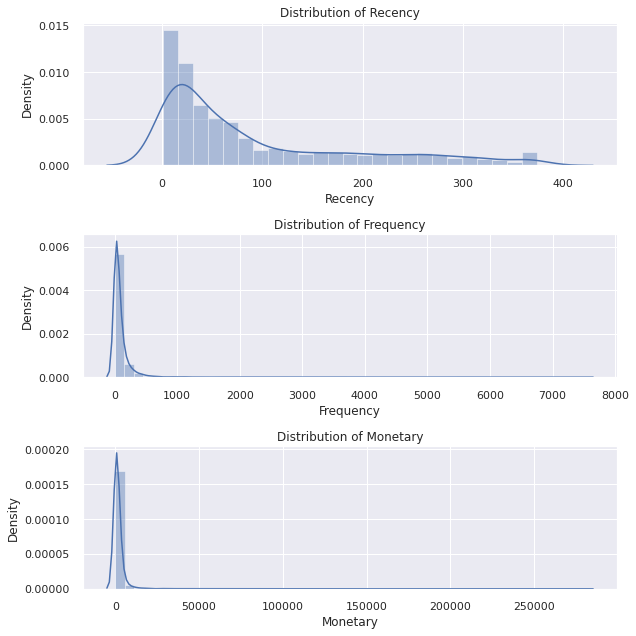

In [69]:
# Plot to check skewness
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm_df,'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm_df,'Frequency')

plt.subplot(3, 1, 3)
check_skew(rfm_df,'Monetary')

plt.tight_layout()

**Removing Skewness**

In [70]:
#Apply handle_neg_n_zero function to Recency and Monetary columns 
rfm_df['Recency'] = [handle_neg_n_zero(x) for x in rfm_df.Recency]
rfm_df['Monetary'] = [handle_neg_n_zero(x) for x in rfm_df.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = rfm_df[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

Recency's: Skew: -0.5539163020068809, : SkewtestResult(statistic=-13.968391843280067, pvalue=2.4305297860916617e-44)
Frequency's: Skew: -0.21822522642703573, : SkewtestResult(statistic=-5.811072263917291, pvalue=6.207395941499347e-09)
Monetary's: Skew: 0.35367147660374587, : SkewtestResult(statistic=9.253271323912841, pvalue=2.1772486762265053e-20)


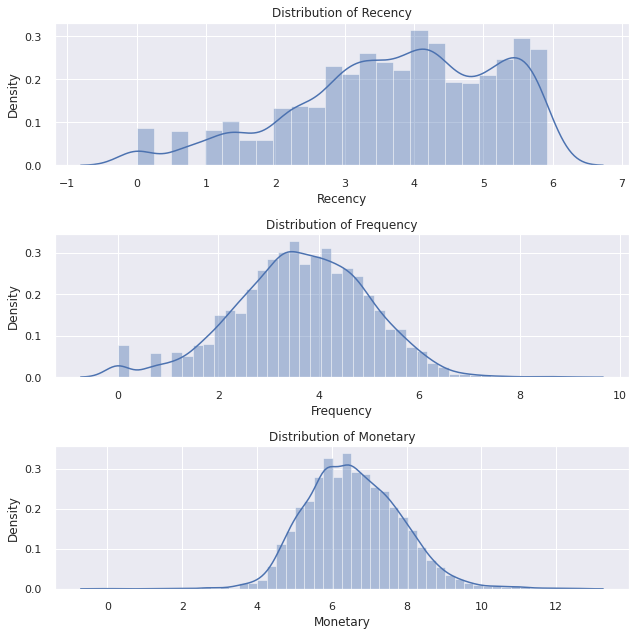

In [71]:
# Check for skewness after log transformation
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(Log_Tfd_Data,'Recency')

plt.subplot(3, 1, 2)
check_skew(Log_Tfd_Data,'Frequency')

plt.subplot(3, 1, 3)
check_skew(Log_Tfd_Data,'Monetary')

plt.tight_layout()

As of now we have completed the first step i.e., building a RFM model.
<br>
Now its time to divide the customers into tiered groups.

In [72]:
#Split into four segments using quantiles
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 18.0, 0.5: 51.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 40.0, 0.75: 97.0},
 'Monetary': {0.25: 305.19, 0.5: 664.0, 0.75: 1650.265}}

Now, lets divide the customer into tiered groups.
<br>

Customer with RFM score 111 - Best or Potential Customer.
<br>
Customer with RFM score 444 - Worst Customer.

In [73]:
#Calculate and Adding R, F and M segment value columns in the existing dataset.
rfm_df['R'] = rfm_df['Recency'].apply(RScoring, args=('Recency',quantiles,))
rfm_df['F'] = rfm_df['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
rfm_df['M'] = rfm_df['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,4,4,1
12347.0,2,182,4310.00,1,1,1
12348.0,75,31,1797.24,3,3,1
12349.0,19,73,1757.55,2,2,1
12350.0,310,17,334.40,4,4,3


Lets assign some names to segments of interest.
<br>
<br>
**Best Customers**– This group consists of those customers who are found in R-Tier-1, F-Tier-1 and M-Tier-1 i.e.,1-1-1, meaning that they transacted recently, do so often and spend more than other customers.
<br>

**High-spending New Customers**– This group consists of those customers in 1-4-1 and 1-4-2. These are customers who transacted only once, but very recently and they spent a lot.
<br>

**Lowest-Spending Active Loyal Customers** – This group consists of those customers in segments 1-1-3 and 1-1-4 (they transacted recently and do so often, but spend the least).
<br>


Marketers should assemble groups of customers most relevant for their particular business objectives and retention goals.

By focusing on the behavioral patterns of particular groups, RFM marketing allows marketers to communicate with customers in a much more effective manner.
<br>
<br>
**Best Customers –** Communications with this group should make them feel valued and appreciated. These customers likely generate a disproportionately high percentage of overall revenues and thus focusing on keeping them happy should be a top priority. Further analyzing their individual preferences and affinities will provide additional opportunities for even more personalized messaging.
<br>

**High-spending New Customers** – It is always a good idea to carefully “incubate” all new customers, but because these new customers spent a lot on their first purchase, it’s even more important. Like with the Best Customers group, it’s important to make them feel valued and appreciated – and to give them terrific incentives to continue interacting with the brand.
<br>

**Lowest-Spending Active Loyal Customers** – These repeat customers are active and loyal, but they are low spenders. Marketers should create campaigns for this group that make them feel valued, and incentivize them to increase their spend levels. As loyal customers, it often also pays to reward them with special offers if they spread the word about the brand to their friends, e.g., via social networks.

In [74]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm_df['RFMGroup'] = rfm_df.R.map(str) + rfm_df.F.map(str) + rfm_df.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
rfm_df['RFMScore'] = rfm_df[['R', 'F', 'M']].sum(axis = 1)
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,326,1,77183.60,4,4,1,441,9
12347.0,2,182,4310.00,1,1,1,111,3
12348.0,75,31,1797.24,3,3,1,331,7
12349.0,19,73,1757.55,2,2,1,221,5
12350.0,310,17,334.40,4,4,3,443,11


In [75]:
rfm_df.RFMScore.describe()

count    4339.000000
mean        7.495736
std         2.815057
min         3.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        12.000000
Name: RFMScore, dtype: float64

The Customers with lower RFM score (starting from 3) are the best customers. And the customers with higher RFM score are worst or not so usefull customer.
<br>
Based on business requirement we can put a threshold and select Target customers.

Now lets apply log function to remove skewness.

In [76]:
rfm_df_scaled = pd.DataFrame()

In [77]:
rfm_df_scaled["Recency"] = np.log(rfm_df.Recency)
rfm_df_scaled["Frequency"] = np.log(rfm_df.Frequency)
rfm_df_scaled["Monetary"] = np.log(rfm_df.Monetary)

In [78]:
rfm_df_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.786897,0.000000,11.253942
12347.0,0.693147,5.204007,8.368693
12348.0,4.317488,3.433987,7.494007
12349.0,2.944439,4.290459,7.471676
12350.0,5.736572,2.833213,5.812338


##**Hierarchical Clustering**

Hierarchical clustering is a method of cluster analysis that seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two categories:
<br>

Agglomerative: This is a "bottom-up" approach: Each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
<br>

Divisive: This is a "top-down" approach: All observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

In [79]:
#creating acopy of dataframe to apply hierarchical model
Hierarchical_model = rfm_df_scaled.copy()

There are different types of linkage. Lets observe few of them.

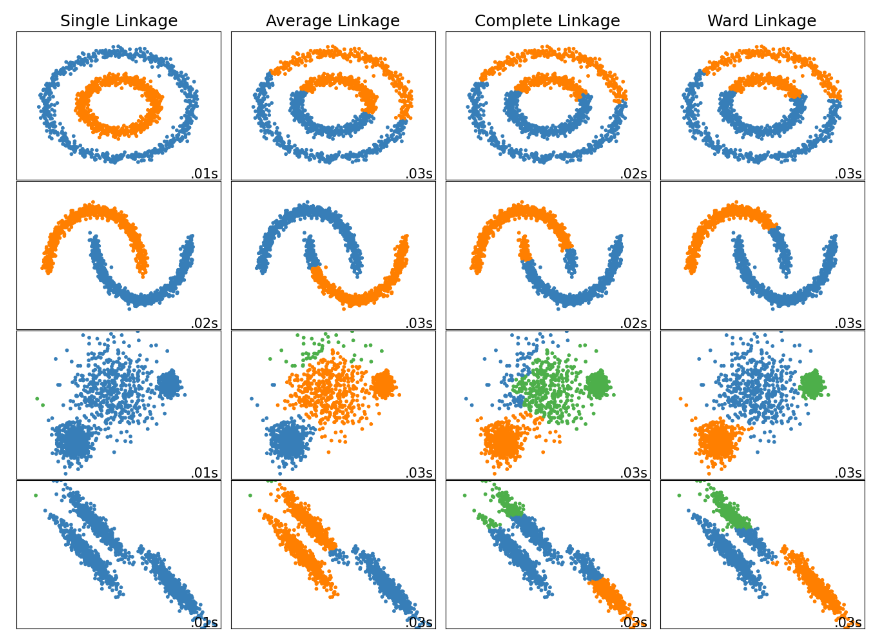

Our data is of Type-3, from the above chart we can observe that it works better in Complete and Ward linkages.
<br>

Comparitively it is better in Ward linkages. But lets apply both complete and ward linkages and Observe the Dendogram.

**Complete Linkage**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.
<br>

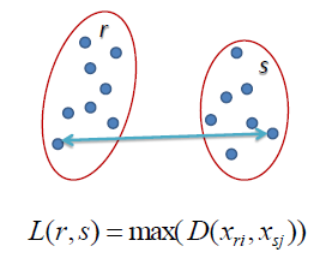

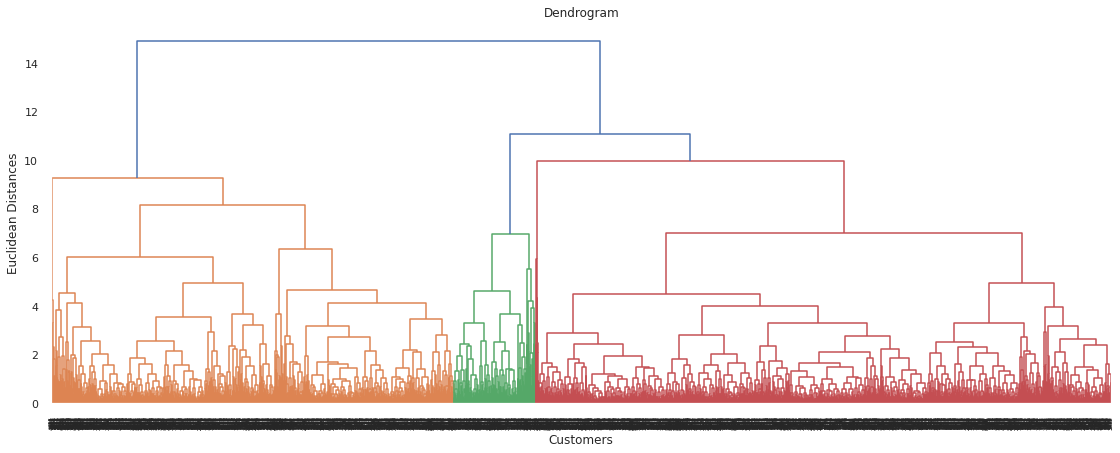

In [80]:
# Using the dendogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(Hierarchical_model, method = 'complete'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show() 

**Ward Linkage**

Ward's procedure is a variance method which attempts to generate clusters to minimise the within-cluster variance. For each cluster, the means for all the variables are computed. Next, for each object, the squared Euclidean distance to the cluster means is calculated. These distances are summed for all the objects.
<br>

Mathematically this can be written as,
<br>
sim(C1,C2)=∑(dist(Pi,Pj))²/(|C1|∗|C2|)

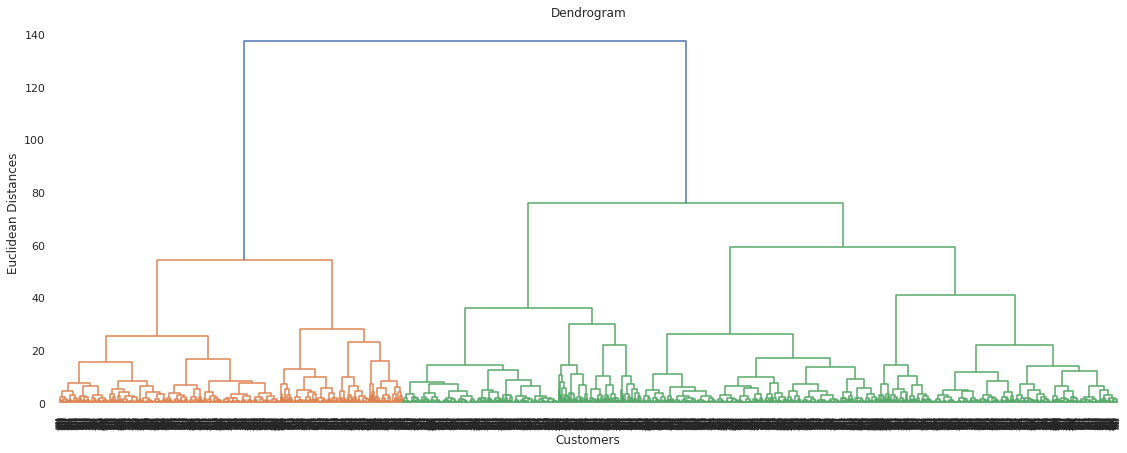

In [81]:
# Using the dendogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(Hierarchical_model, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show()

Now we need to find the largest vertical distance we can make without crossing any other horizontal line.


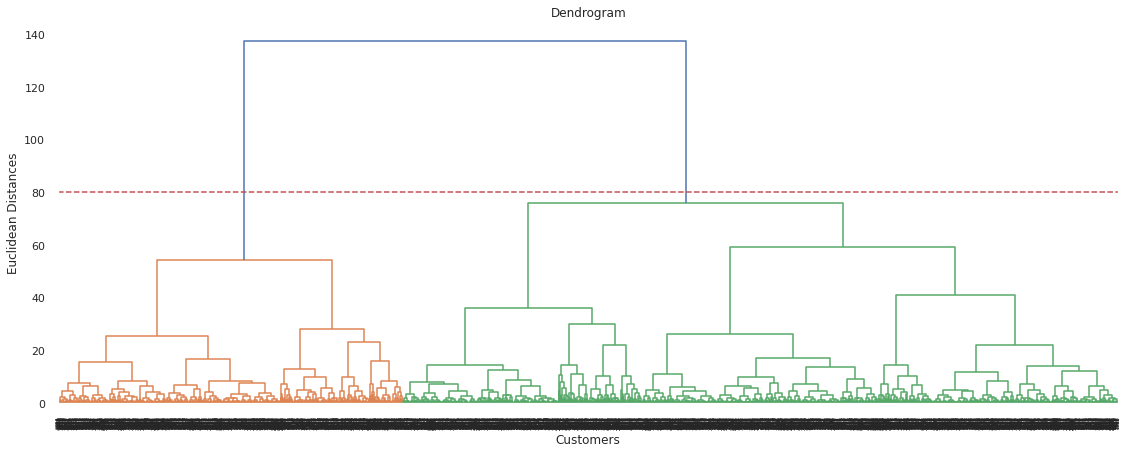

In [82]:
dendrogram = sch.dendrogram(sch.linkage(Hierarchical_model, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=80, color='r', linestyle='--')
plt.show()

Now lets apply Agglomerative Clustering with 'ward' linkage.

In [83]:
# Fitting hierarchical clustering to the mall dataset
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
Hierarchical_model["cluster"] = hc.fit_predict(Hierarchical_model)

In [84]:
Hierarchical_model.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346.0,5.786897,0.000000,11.253942,0
12347.0,0.693147,5.204007,8.368693,1
12348.0,4.317488,3.433987,7.494007,0
12349.0,2.944439,4.290459,7.471676,1
12350.0,5.736572,2.833213,5.812338,0


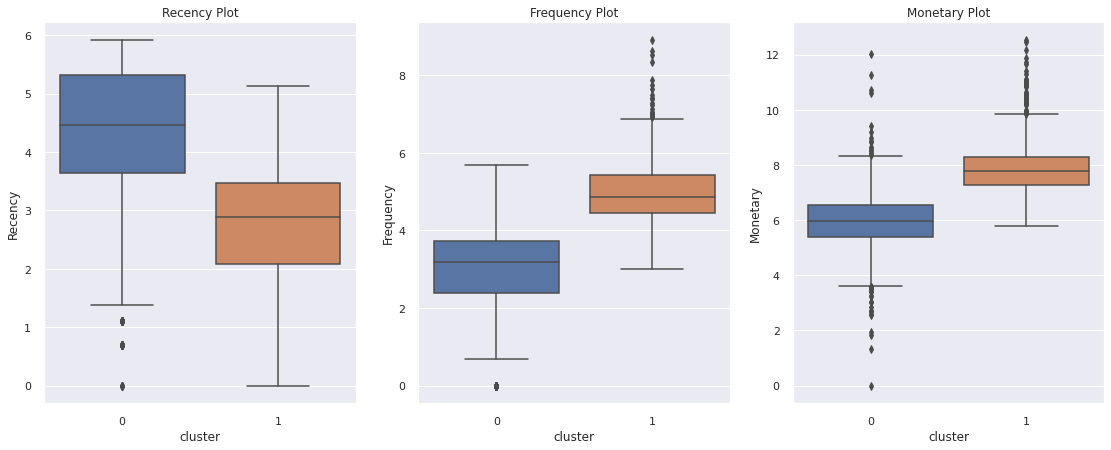

In [85]:
# plot
plt.figure(figsize=(19,7))
plt.subplot(1, 3, 1)
plt.title("Recency Plot")
sns.boxplot(x='cluster', y='Recency', data=Hierarchical_model)
plt.subplot(1, 3, 2)
plt.title("Frequency Plot")
sns.boxplot(x='cluster', y='Frequency', data=Hierarchical_model)
plt.subplot(1,3,3)
plt.title("Monetary Plot")
sns.boxplot(x='cluster', y='Monetary', data=Hierarchical_model)
plt.show()

Based on 'Wards linkage' we have created 2 clusters.
<br>

Cluster 0 are the group of customers who is not so recent (shopped few/many days ago) and not so frequent and spends less money.
<br>

Cluster 1 are group of customers who are more recent (shopped recently) , more frequent and spends more money.

##**Kmeans Clustering**

It is an iterative algorithm that divides the unlabeled dataset into k different clusters in such a way that each dataset belongs only one group that has similar properties.

In [86]:
#creating a copy of dataframe to apply kmeans model
Kmeans_model = rfm_df_scaled.copy()

The main disadvantage of Kmeans clustering is we need to define 'K' in the begining.
<br>
So, to decide 'K' in kmeans clustering we have few methods -


*   Silhouette score
*   Elbow method
<br>

Lets apply both of them and identify the optimal number of clusters.



In [87]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(Kmeans_model)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(Kmeans_model, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.39413633544128285
For n_clusters=3, the silhouette score is 0.3024133486477002
For n_clusters=4, the silhouette score is 0.3062008454888503
For n_clusters=5, the silhouette score is 0.2810694412494397
For n_clusters=6, the silhouette score is 0.2836323199249324
For n_clusters=7, the silhouette score is 0.27198045920466163
For n_clusters=8, the silhouette score is 0.26824421265279025


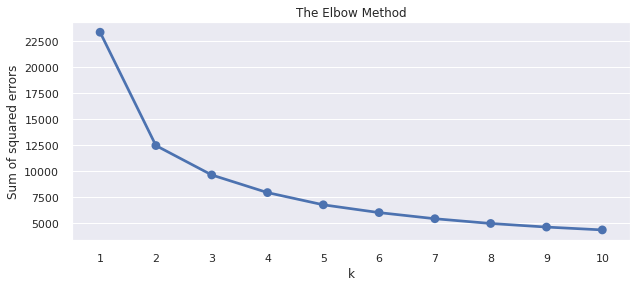

In [88]:
### Features Used in training K Means - Log Transformed Recency, Frequency and Monetary values
data_norm = Kmeans_model[["Recency", "Frequency", "Monetary"]]

sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
    
# Plotting the elbow plot
plt.figure(figsize=(10,4))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Based on Silhouette score and Elbow method, we can consider the optimal number of clusters as 3.
<br> 
Now I am bulding K-means model using k=3.

In [89]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, random_state=1)
kmeans.fit(data_norm)
Kmeans_model["cluster"] = kmeans.predict(data_norm)

In [90]:
Kmeans_model.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346.0,5.786897,0.000000,11.253942,1
12347.0,0.693147,5.204007,8.368693,2
12348.0,4.317488,3.433987,7.494007,1
12349.0,2.944439,4.290459,7.471676,1
12350.0,5.736572,2.833213,5.812338,0


Checking Mean RFM values in different clusters to understand cluster properties

In [91]:
Kmeans_model.groupby(["cluster"])[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
cluster,,,
0,4.872435,2.389950,5.435638
1,3.815818,3.962120,6.761971
2,1.948716,5.082502,8.018419


We have grouped our data into 3 clusters - 0,1 and 2.
<br>

The customer who comes under **Cluster 0** are not so recent, not so frequent and won't spend more money. So, this group of customers are not so usefull for us.
<br>

The customer who comes under **Cluster 1** are some what more recent,frequent and spend some what more money compared to Cluster 0.
<br>

The customer who comes under **Cluster 2** are Best/Potential customers (we cannot loose them) because they are very recent, more frequent and spend more money aswell.


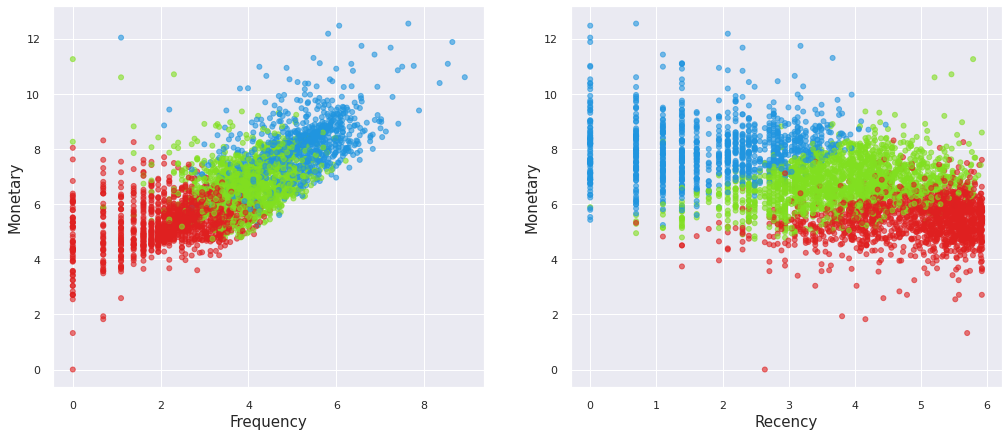

In [92]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to dataframe
Kmeans_model['cen_x'] = Kmeans_model.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
Kmeans_model['cen_y'] = Kmeans_model.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
Kmeans_model['c'] = Kmeans_model.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Plot clusters
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.scatter(Kmeans_model.Frequency, Kmeans_model.Monetary, c=Kmeans_model.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)
plt.subplot(1,2,2)
plt.scatter(Kmeans_model.Recency, Kmeans_model.Monetary, c=Kmeans_model.c, alpha = 0.6, s=25)
plt.xlabel('Recency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)
plt.show()

Here Red color represents Cluster 0, Green color represents Cluster 1 and Blue color represents Cluster 2.
<br>

In Monetary vs Frequency plot we can observe that Blue grouped customers (i.e., Cluster 2) are more frequent and spend more money.
<br>

In Monetary vs Recency plot we can observe that Blue grouped customers (i.e., Cluster 2) are more recent i.e, they shopped recently and spend more money.

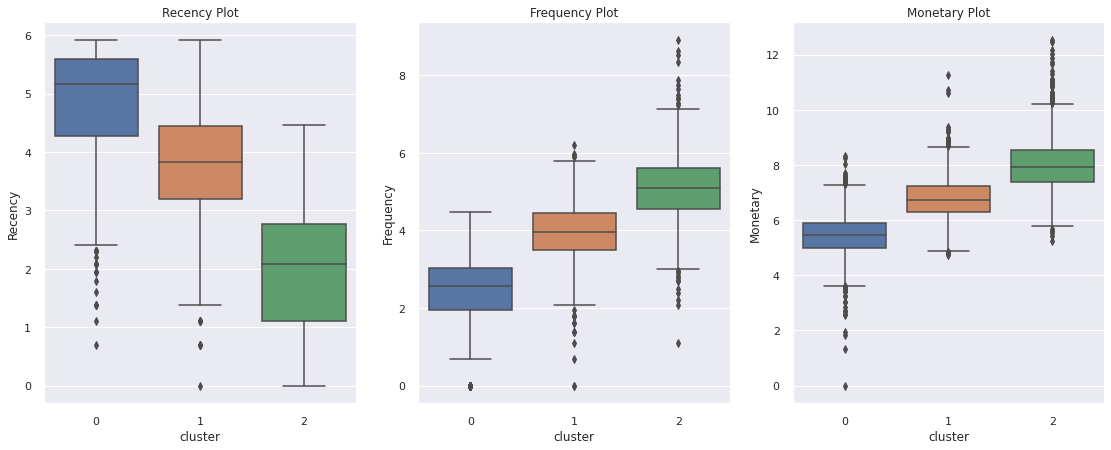

In [93]:
# plot
plt.figure(figsize=(19,7))
plt.subplot(1, 3, 1)
plt.title("Recency Plot")
sns.boxplot(x='cluster', y='Recency', data=Kmeans_model)
plt.subplot(1, 3, 2)
plt.title("Frequency Plot")
sns.boxplot(x='cluster', y='Frequency', data=Kmeans_model)
plt.subplot(1,3,3)
plt.title("Monetary Plot")
sns.boxplot(x='cluster', y='Monetary', data=Kmeans_model)
plt.show()

Even this box plot also signifies the same. 
<br>

Cluster 0 has less recent (shopped few/many days ago), less frequent and less monetary (spends lesss money) customers
<br>

Cluster 1 has comparitively high recent, high frequent and more monetary than Cluster 0.
<br>

Cluster 2 is more recent, more frequent and high monetary.

#**Conclusion**

We initially started with exploring the dataset got familiarized ourselves with the features, handled missing and duplicate values aswell then started with the  EDA. Through analysis we came up with few conclusions like - 


*   About 88.8% of orders are coming from UK, so we can say that most customers and most orders will be from United Kingdom.
*   And we have also observed the Saudi Arabia is the least country with orders. We can try to implement some strategy to attract more customers in Saudi Arabia.


*   Shopping is more on weekdays compared to weekend.
*   Shoppings will be more on year ends i.e, Sep, Oct, Nov and Dec.
We can even say that since festivals will be more during this period shopping will be more.


*   We have even observed that most of the purchase happens during Afternoon.









In Model building, firstly we started with a marketing technique called **RFM segmentation.**
<br>
RFM segmentation is used to quantitatively rank and group customers based on the recency, frequency and monetary to identify the best customers and perform targeted marketing campaigns.
<br>
Customer with RFM score 111 (i.e, Recency-1, Frequency-1,Monetary-1) - Best or Potential Customer.
<br>
Customer with RFM score 444 (i.e, Recency-4,Frequency-4,Monetary-4) - Worst Customer.
<br>

We have even named few segments of interest - Best Customers, High-spending new customers, Low spending active loyal customers.
<br>

Marketers should assemble groups of customers most relevant for their particular business objectives and retention goals.

Then we applied few of the unisupervised machine learning algorithms -
<br>

1. **Hierarchical Clustering**
2. **Kmeans Clustering**
<br>
<br>

In Hierarchical Clustering through dendogram we figured out and created 2 clusters.
<br>
In Kmeans Clustering through silhouette score and Elbow method we figured out and created 3 clusters.

Instead of using just 2 clusters it is better to use 3 clusters for more detailed analysis. So we will be treating Kmeans Clustering as our best performed algorithm and lets see the segments we got out of Kmeans Clustering.
<br>

**Low Value Customers**
<br>
'Cluster 0' customers can be called Low valued customers because they are less frequent, spends less money and they have purchased long time ago.
<br>

**Average value Customers**
<br>
'Cluster 1' customers can be called has  Average valued customers because they are some what more recent, frequent and spend some what more money compared to Low value customers. These customers could become high risk and we should aggressively market towards them with great deals so we don't lose them forever.

**High value Customers**
<br>
'Cluster 2' customers can be grouped has High valued customers because they are very recent (shopped recently), more frequent and spend more money aswell. 
<br>
These are our best or potential customers we should not lose them. Communications with this group make them feel valued and appreciated. These customers likely generate a disproportionately high percentage of overall revenues and thus focusing on keeping them happy should be a top priority. Further analyzing their individual preferences and affinities we can provide additional opportunities for even more personalized messaging.

**Lets visualize these segments in 3D plot.**

In [94]:
fig = px.scatter_3d(Kmeans_model, x='Recency', y='Frequency', z='Monetary',
              color='cluster')
fig.show()